In [3]:
import re
import os
import sys
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from Bio import SeqIO, pairwise2, AlignIO
from Bio.Align import AlignInfo, MultipleSeqAlignment
from collections import Counter, namedtuple
# importlib.reload(sys.modules['Evaluation.DfamEvaluation'])
import importlib
from DataStructure import PositionInfo
from Sequence import Sequence
from Evaluation.DfamEvaluation import DfamEvaluation
from SharedInfo import currDatasetName, cutterA, cutterB, colorA, colorB
from Util.SeqUtil import seqInfo
from Util.PlotUtil import basicPlot, twoLabelBasicPlot, lengthScatterDistributionPlot
from Util.AnalysisUtil import listToSortedCounter, getStatisticData, mostCommonTable

In [2]:
fileName = "chrX_FullLength_LTR_dm6_dfam.nrph.hits"
currDatasetName = "chrX_dm6"

In [3]:
seqA = Sequence(cutterA)
parseFastaA = seqA.parseFasta()
fragmentLenListA, fragmentSeqListA = seqA.parseSeqByCutter()
repeatInfoListA = seqA.findRepeatSeqs()
repeatPositionListA = seqA.getRepeatPositionList()

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.15776801109313965 sec to parse fasta file ...
...start parse seq by cutter: GATC
...cost 0.3292391300201416 sec to cut sequence
... start finding repeat seq ...
...cost0.0713968276977539 sec to finding repeat seq  ...


In [4]:
seqB = Sequence(cutterB)
parseFastaB = seqB.parseFasta()
fragmentLenListB, fragmentSeqListB = seqB.parseSeqByCutter()
repeatInfoListB = seqB.findRepeatSeqs()
repeatPositionListB = seqB.getRepeatPositionList()

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.14873790740966797 sec to parse fasta file ...
...start parse seq by cutter: AAGCTT
...cost 0.34766411781311035 sec to cut sequence
... start finding repeat seq ...
...cost0.00609588623046875 sec to finding repeat seq  ...


In [5]:
seqInfo(currDatasetName, parseFastaA)

chrX_dm6 dataset
 number of sequence:1
 total length:23542271



In [6]:
repeatPositionList = repeatPositionListA + repeatPositionListB

In [7]:
print(f'Check cutter A, B: \n {len(repeatPositionList)} = {len(repeatPositionListA)} + {len(repeatPositionListB)}')

Check cutter A, B: 
 69683 = 66728 + 2955


In [8]:
repeatPositionList[1]

PositionInfo(startIdx=432, endIdx=647)

In [12]:
dfam = DfamEvaluation(repeatPositionList, hitFileName="chrX_ROO_LTR_dm6.hits.hit")

In [13]:
repeatPositionLookupDic = dfam.positionBucketClassifier()
dfamPositionList = dfam.getDfamPositionList()

In [6]:
ROO_LTR_df = pd.read_csv('./Evaluation/Source/ROO_LTR_Seq.csv')
ROO_LTR_df.columns

Index(['index', 'seq', 'seqLength'], dtype='object')

In [4]:
conSeq = Sequence(cutterA)
conParseFasta = conSeq.parseFasta()

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.13412976264953613 sec to parse fasta file ...


In [8]:
# From here
consensusSeq = conParseFasta[0] 
familySeqList = list(ROO_LTR_df['seq'])
dfam = DfamEvaluation([])
familySeqSimilarityList = dfam.refFaimlySimilarity(consensusSeq,familySeqList)

In [3]:
familySeqSimilarityList

NameError: name 'familySeqSimilarityList' is not defined

In [127]:
# from Dfam , check repeat
DRrepeatMatchList, DRmatchedFamilyAccList, DRmatchedFamilyNameList = dfam.checkDfamMatchWithRepeat()

In [34]:
# from repeat , check Dfam
# RDrepeatMatchList, RDmatchedFamilyAccList, RDmatchedFamilyNameList = dfam.checkRepeatMatchWithDfam()

In [128]:
len(DRrepeatMatchList)

602

In [36]:
dfam.familyMatchRatio(DRmatchedFamilyAccList)
dfam.matchRatio(DRrepeatMatchList)
unMatchDf = dfam.getUnmatchInfo(DRrepeatMatchList)

Family Match Result:
matchCount:55	dfamCount:55	Ratio:1.0
unmatch acc: set()
matchCount:597	dfamCount:602	Ratio:0.9916943521594684
count      5.000000
mean     132.000000
std       67.052218
min       61.000000
25%       85.000000
50%      119.000000
75%      166.000000
max      229.000000
dtype: float64


In [101]:
# lengthScatterDistributionPlot(list(unMatchDf["length"]))

In [97]:
def getSequenceLengthAnalsis(inputLengthList, num=10):
    """
    1. count of common length 
    2. statistic info
    3. distribution plot
    """
    mostCommonTable(Counter(inputLengthList).most_common(num), num)
    getStatisticData(inputLengthList)
    sortedCounterList = listToSortedCounter(inputLengthList)
    basicPlot(sortedCounterList)

In [151]:
totalDfam = DfamEvaluation(repeatPositionList, hitFileName="chrX_dm6_dfam.nrph.hits")
totalRepeatPositionLookupDic = totalDfam.positionBucketClassifier()
totalDfamPositionList = totalDfam.getDfamPositionList()
totalList = [ i.endIdx - i.startIdx  for i in totalDfamPositionList]
totalSortedCounterList = listToSortedCounter(totalList)

In [152]:
dfamSeqLenList = [ i.endIdx - i.startIdx for i in dfamPositionList ]
LTRSortedCounterList = listToSortedCounter(dfamSeqLenList)

(0.0, 1500.0)

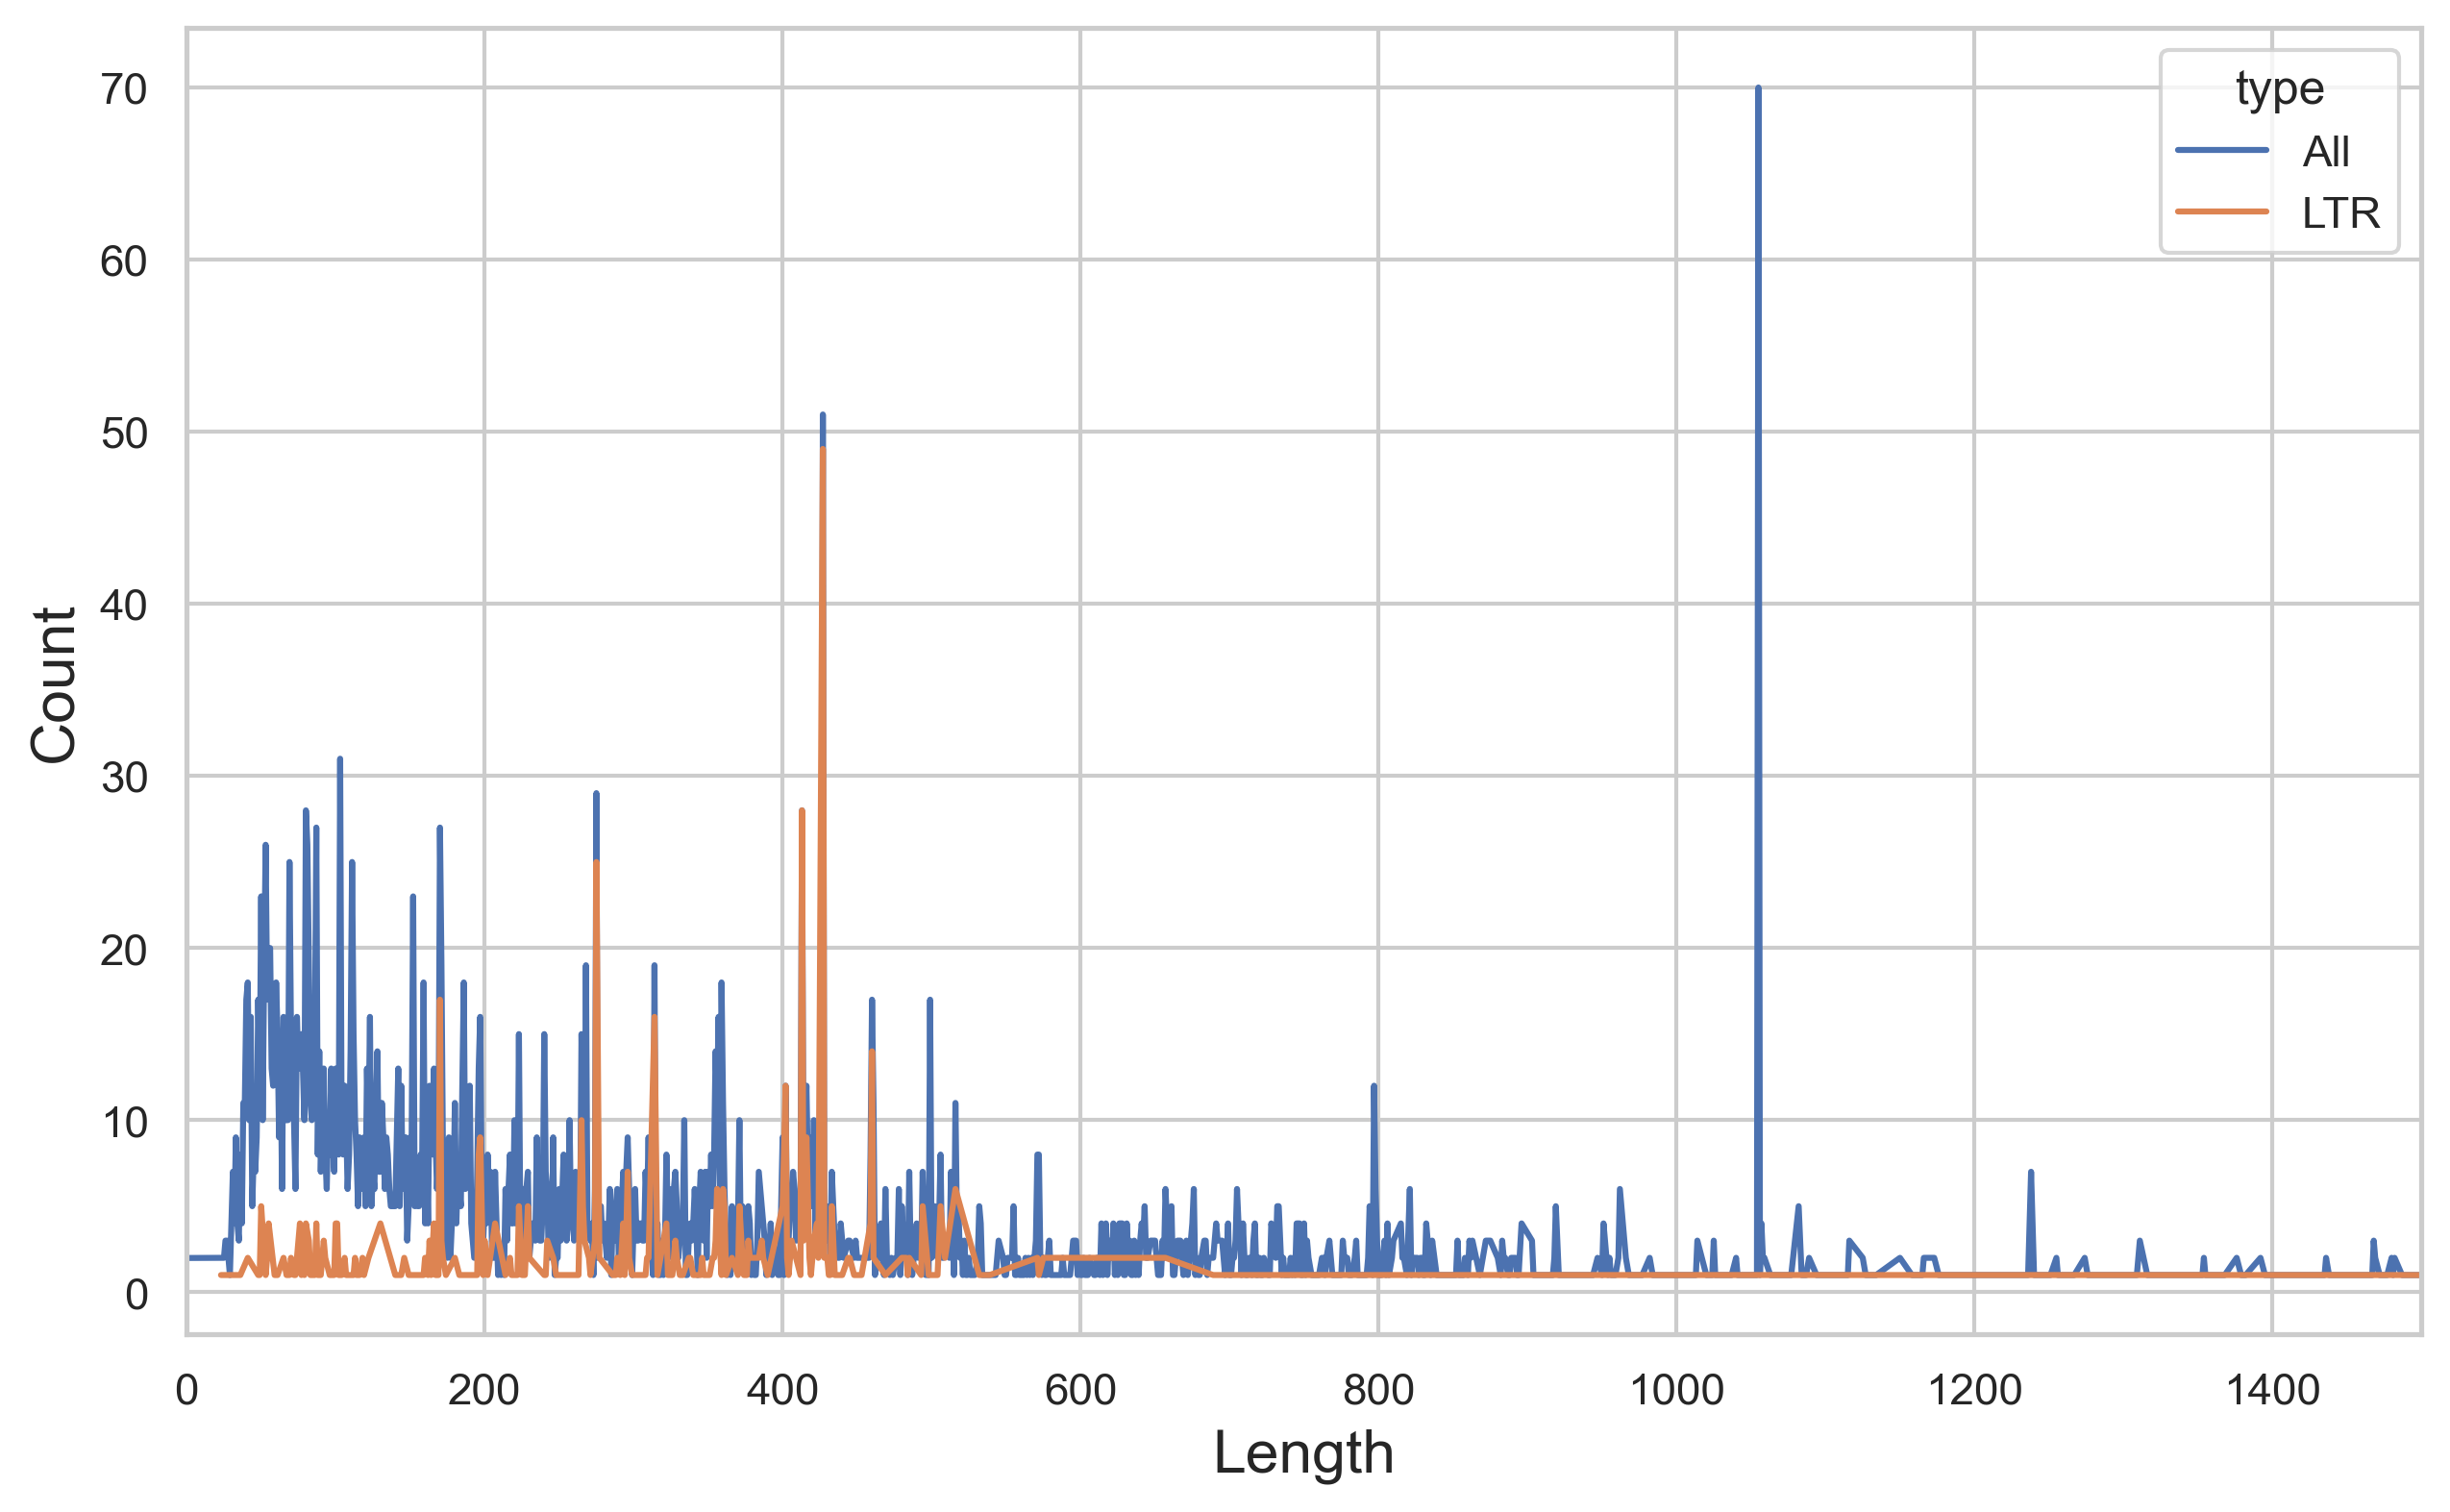

In [155]:
df = pd.DataFrame(columns=["x", "y", "type"], dtype=float)
for row in totalSortedCounterList:
    df = df.append({"x": row[0], "y": row[1], "type": "All"}, ignore_index=True)
for row in LTRSortedCounterList:
    df = df.append({"x": row[0], "y": row[1], "type": "LTR"}, ignore_index=True)

df.fillna(np.nan, inplace=True)
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")
sns.lineplot(data=df, x="x", y="y", hue="type")
ax.set_xlabel("Length", size=15)
ax.set_ylabel("Count", size=15)
ax.set_xlim(0, 1500)

In [103]:
# Dfam ref sequence 
# dfamSeqLenList = [ i.endIdx - i.startIdx for i in dfamPositionList ]
# getSequenceLengthAnalsis(dfamSeqLenList)

In [99]:
# Repeat sequence
# repeatFragmentLenList = [ i.endIdx - i.startIdx for i in repeatPositionList ]
# getSequenceLengthAnalsis(repeatFragmentLenList)

In [69]:
# Test cutter A
# dfamA = DfamEvaluation(repeatInfoListA)
# repeatPositionListA = dfamA.getRepeatPositionList()
# repeatPositionLookupDicA = dfamA.positionBucketClassifier()
# dfamPositionListA = dfamA.getDfamPositionList()
# dfamPositionLookupDicA = dfamA.positionBucketClassifier()
# DRrepeatMatchListA, DRmatchedFamilyAccListA, DRmatchedFamilyNameListA = dfamA.checkDfamMatchWithRepeat()

In [22]:
# totalLen = len(DRrepeatMatchListA)
# matchLenA = len(list(filter(lambda x: x, DRrepeatMatchListA)))
# ratio = matchLenA / totalLen
# print(f"matchCount:{matchLenA}\tdfamCount:{totalLen}\tRatio:{ratio}")

In [23]:
# Test cutter B
# dfamB = DfamEvaluation(repeatInfoListB)
# repeatPositionListB = dfamB.getRepeatPositionList()
# repeatPositionLookupDicB = dfamB.positionBucketClassifier()
# dfamPositionListB = dfamB.getDfamPositionList()
# dfamPositionLookupDicB = dfamB.positionBucketClassifier()
# DRrepeatMatchListB, DRmatchedFamilyAccListB, DRmatchedFamilyNameListB = dfamB.checkDfamMatchWithRepeat()

In [24]:
# totalLen = len(DRrepeatMatchListB)
# matchLenB = len(list(filter(lambda x: x, DRrepeatMatchListB)))
# ratio = matchLenB / totalLen
# print(f"matchCount:{matchLenB}\tdfamCount:{totalLen}\tRatio:{ratio}")

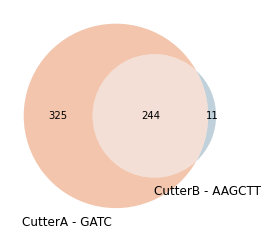

In [22]:
# plt.figure(linewidth=10, facecolor="white", dpi=1200)
plt.figure(linewidth=10, facecolor="white")
v = venn2(subsets = (325, 11, 244), set_labels = (f'CutterA - {cutterA} ', f'CutterB - {cutterB}'), set_colors=(colorA, colorB))
plt.show()
